In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob, json
import numpy as np
import pandas as pd
import s4_authors_stats as s4
import dask.dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.stats import pearsonr, spearmanr
from matplotlib.colors import LogNorm

from functools import partial
from multiprocessing import Pool

In [19]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

In [22]:
# pairs_authors_dd = dd.read_csv('data/PairAuthors2csv_split/pair_processed_join*', sep='\t', header=None, names=['author_id', 'cits'])
# pairs_authors_dd = pairs_authors_dd.set_index('author_id', sorted=True)
# pairs_authors_dd.head()

,cits
author_id,
5211,"{""1141255472"": [14], ""1970691061"": [0, 0, 1, 4..."
6478,"{""1088438710"": [43], ""1238614089"": [94], ""1278..."
11720,"{""1214880279"": [23, 35, 41, 24], ""1250321752"":..."
15251,"{""105506866"": [93], ""1061427020"": [33, 93], ""1..."
16490,"{""1156106740"": [10, 2, 23, 24], ""1355423769"": ..."


In [23]:
# authors_infos = dd.read_json('data/author_infos_processed.txt', orient='index')
# authors_infos.head()

,birth_year,citation_count
1243978490,2002,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0..."
2250382311,1982,"[0, 15.0, 2.0, 0, 0, 4.0, 1.0, 0, 87.0, 6.0, 6..."
2223209249,1994,"[0, 1.0, 2.0, 9.0, 4.0, 1.0, 4.0, 7.0, 2.0, 0,..."
2970207820,1994,"[2.0, 0, 1.0, 6.0, 44.0, 0, 0, 0, 2.0, 0, 0, 0..."
2112958178,1981,"[0, 0, 0, 0, 0, 6.0, 1.0, 0, 5.0, 0, 0, 3.0, 0..."


In [24]:
# pairs_authors_dd = pairs_authors_dd.merge(authors_infos, left_index=True, right_index=True)
# pairs_authors_dd.head()

,cits,birth_year,citation_count
5211,"{""1141255472"": [14], ""1970691061"": [0, 0, 1, 4...",2005,"[0, 1.0, 1.0, 7.0, 10.0, 0, 46.0, 18.0, 29.0, ..."
6478,"{""1088438710"": [43], ""1238614089"": [94], ""1278...",1994,"[0, 2.0, 5.0, 4.0, 0, 0, 7.0, 9.0, 10.0, 13.0,..."
11720,"{""1214880279"": [23, 35, 41, 24], ""1250321752"":...",1999,"[2.0, 0, 0, 0, 0, 3.0, 0, 0, 4.0, 2.0, 1.0, 0,..."
15251,"{""105506866"": [93], ""1061427020"": [33, 93], ""1...",1995,"[0, 0, 0, 0, 0, 0, 0, 8.0, 10.0, 0, 0, 27.0, 1..."
16490,"{""1156106740"": [10, 2, 23, 24], ""1355423769"": ...",1998,"[0, 0, 0, 0, 0, 0, 0, 0, 3.0, 1.0, 3.0, 7.0, 0..."


In [25]:
# header = '/mnt/e/MAG/mag-2021-01-05/advanced/'
# fields_infos = 'FieldsOfStudy.txt'
# fos_infos = pd.read_csv(header+fields_infos, header=None, sep='\t')[[0, 1, 2]]
# fos_infos.columns = ['field_id', 'rank', 'normalized_name']

In [28]:
# authors_fos = dd.read_csv('data/valid_authors_fos_full.csv', sep='\t', header=None, names=['author_id', 'weights', 'fos'])
# authors_fos.head()

,author_id,weights,fos
0,5211,"{""185592680"": 2.600569523069523, ""192562407"": ...",86803240
1,6478,"{""121332964"": 0.10876623376623376, ""71924100"":...",86803240
2,11720,"{""121332964"": 6.217338772338771, ""185592680"": ...",185592680
3,15251,"{""127313418"": 0.3997965768799102, ""86803240"": ...",86803240
4,16490,"{""121332964"": 3.3598429096156375, ""205649164"":...",86803240


In [29]:
authors_complete = authors_fos.merge(pairs_authors_dd, left_on='author_id', right_index=True)
authors_complete.head()

,author_id,weights,fos,cits,birth_year,citation_count
0,5211,"{""185592680"": 2.600569523069523, ""192562407"": ...",86803240,"{""1141255472"": [14], ""1970691061"": [0, 0, 1, 4...",2005,"[0, 1.0, 1.0, 7.0, 10.0, 0, 46.0, 18.0, 29.0, ..."
1,6478,"{""121332964"": 0.10876623376623376, ""71924100"":...",86803240,"{""1088438710"": [43], ""1238614089"": [94], ""1278...",1994,"[0, 2.0, 5.0, 4.0, 0, 0, 7.0, 9.0, 10.0, 13.0,..."
2,11720,"{""121332964"": 6.217338772338771, ""185592680"": ...",185592680,"{""1214880279"": [23, 35, 41, 24], ""1250321752"":...",1999,"[2.0, 0, 0, 0, 0, 3.0, 0, 0, 4.0, 2.0, 1.0, 0,..."
3,15251,"{""127313418"": 0.3997965768799102, ""86803240"": ...",86803240,"{""105506866"": [93], ""1061427020"": [33, 93], ""1...",1995,"[0, 0, 0, 0, 0, 0, 0, 8.0, 10.0, 0, 0, 27.0, 1..."
4,16490,"{""121332964"": 3.3598429096156375, ""205649164"":...",86803240,"{""1156106740"": [10, 2, 23, 24], ""1355423769"": ...",1998,"[0, 0, 0, 0, 0, 0, 0, 0, 3.0, 1.0, 3.0, 7.0, 0..."


In [30]:
# from dask.diagnostics import ProgressBar
# with ProgressBar():
#     authors_complete.to_csv('data/AuthorsMetrics_split/authors_metrics_*', sep='\t', header=None)

[########################################] | 100% Completed | 20min 58.0s


In [3]:
from s4_authors_stats import _step_1
authors_complete = dd.read_csv('data/AuthorsMetrics_split/authors_metrics_*', sep='\t', header=None)
authors_complete = authors_complete.set_index(1, sorted=True)
print(authors_complete.head())

       0                                                  2          3  \
1                                                                        
5211   0  {"185592680": 2.600569523069523, "192562407": ...   86803240   
6478   1  {"121332964": 0.10876623376623376, "71924100":...   86803240   
11720  2  {"121332964": 6.217338772338771, "185592680": ...  185592680   
15251  3  {"127313418": 0.3997965768799102, "86803240": ...   86803240   
16490  4  {"121332964": 3.3598429096156375, "205649164":...   86803240   

                                                       4     5  \
1                                                                
5211   {"1141255472": [14], "1970691061": [0, 0, 1, 4...  2005   
6478   {"1088438710": [43], "1238614089": [94], "1278...  1994   
11720  {"1214880279": [23, 35, 41, 24], "1250321752":...  1999   
15251  {"105506866": [93], "1061427020": [33, 93], "1...  1995   
16490  {"1156106740": [10, 2, 23, 24], "1355423769": ...  1998   

                  

In [4]:
authors_complete = authors_complete[[2, 3, 4, 5, 6]]
authors_complete.columns = ['weights', 'fos', 'cits', 'birth_year', 'citation_count']
authors_complete.head()

,weights,fos,cits,birth_year,citation_count
1,,,,,
5211,"{""185592680"": 2.600569523069523, ""192562407"": ...",86803240,"{""1141255472"": [14], ""1970691061"": [0, 0, 1, 4...",2005,"[0, 1.0, 1.0, 7.0, 10.0, 0, 46.0, 18.0, 29.0, ..."
6478,"{""121332964"": 0.10876623376623376, ""71924100"":...",86803240,"{""1088438710"": [43], ""1238614089"": [94], ""1278...",1994,"[0, 2.0, 5.0, 4.0, 0, 0, 7.0, 9.0, 10.0, 13.0,..."
11720,"{""121332964"": 6.217338772338771, ""185592680"": ...",185592680,"{""1214880279"": [23, 35, 41, 24], ""1250321752"":...",1999,"[2.0, 0, 0, 0, 0, 3.0, 0, 0, 4.0, 2.0, 1.0, 0,..."
15251,"{""127313418"": 0.3997965768799102, ""86803240"": ...",86803240,"{""105506866"": [93], ""1061427020"": [33, 93], ""1...",1995,"[0, 0, 0, 0, 0, 0, 0, 8.0, 10.0, 0, 0, 27.0, 1..."
16490,"{""121332964"": 3.3598429096156375, ""205649164"":...",86803240,"{""1156106740"": [10, 2, 23, 24], ""1355423769"": ...",1998,"[0, 0, 0, 0, 0, 0, 0, 0, 3.0, 1.0, 3.0, 7.0, 0..."


In [72]:
# h_index, cits, n_papers, birth, max_ws, max_colabs, citation_list, colabs_cit_list, authors_id = s4.step_1(pairs_authors_dd)
# with ProgressBar():
#     s4.step_1(authors_complete).to_csv('data/AuthorsMetrics_split/authors_v2_metrics_*', sep='\t', header=None)

H, C, P, WS, WP, CL, Y, CH, FOS = s4.step_1(authors_complete)

2630313it [28:37, 1531.63it/s]


In [73]:
open('results/hindex_full.json','w').write(json.dumps(H))
open('results/cits_full.json','w').write(json.dumps(C))
open('results/papers_full.json','w').write(json.dumps(P))
open('results/ws_full.json','w').write(json.dumps(WS))
open('results/wp_full.json','w').write(json.dumps(WP))
open('results/citlist_full.json','w').write(json.dumps(CL))
open('results/birth_full.json', 'w').write(json.dumps(Y))
open('results/fos_full.json','w').write(json.dumps(FOS))
open('results/ch_full.json', 'w').write(json.dumps(CH))

851213573

In [84]:
H = json.load(open('results/hindex_full.json'))
C = json.load(open('results/cits_full.json'))
P = json.load(open('results/papers_full.json'))
WS = json.load(open('results/ws_full.json'))
WP = json.load(open('results/wp_full.json'))
CL = json.load(open('results/citlist_full.json'))
Y = json.load(open('results/birth_full.json'))
CH = json.load(open('results/ch_full.json'))
FOS = json.load(open('results/fos_full.json'))

In [85]:
unique = np.unique(FOS)
H = np.asarray(H)
C = np.asarray(C)
P = np.asarray(P)
WS = np.asarray(WS)
WP = np.asarray(WP)
CL = np.asarray(CL)
Y = np.asarray(Y)
CH = np.asarray(CH)
FOS = np.asarray(FOS)
#TODO ajeitar o HINDEX pra rank funcionar

/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [17]:
header = '/mnt/e/MAG/mag-2021-01-05/advanced/'
fields_infos = 'FieldsOfStudy.txt'
fos_infos = pd.read_csv(header+fields_infos, header=None, sep='\t')[[0, 1, 2]]
fos_infos.columns = ['field_id', 'rank', 'normalized_name']

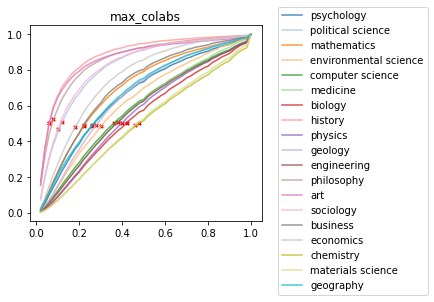

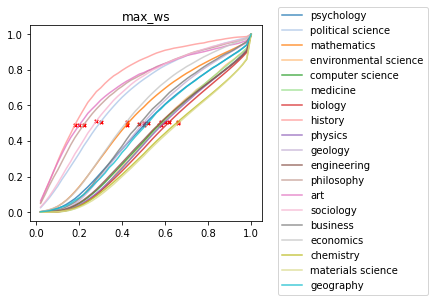

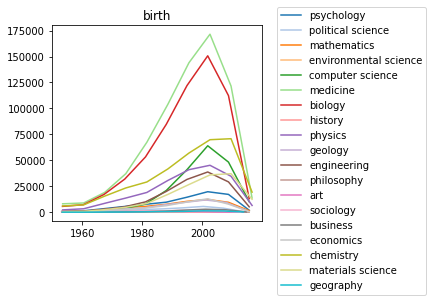

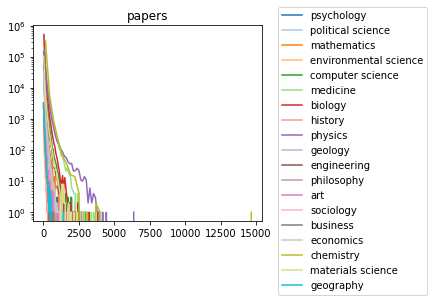

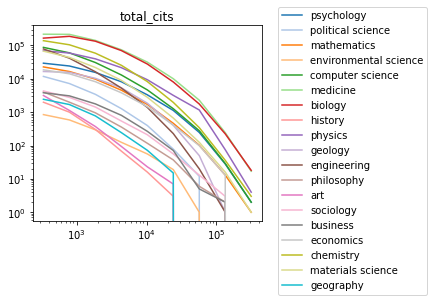

In [105]:
def plot_hist(fig, group, bins, field_name, cumulative):
    y,x = np.histogram(group, bins=bins)
    median = np.percentile(group, 50)
    if cumulative:
        y = np.cumsum(y)
        argy = np.argmin(np.abs(x[1:] - median))
        fig.scatter([x[argy+1]], [y[argy]/y[-1]], color='r', s=12, marker='x')
        fig.plot(x[1:], y/y[-1], label=field_name, alpha=0.8)
    else:
        bins_center = 0.5*(x[:-1]+x[1:])
        fig.plot(bins_center,y, label=field_name)
    
def basic_hist(unique, fos, data, key, bins, yscale=None, xscale=None, cumulative=False):
    fig, ax = plt.subplots()
    for field in unique:
        group = data[fos == field]
        if len(group) < 1000:
            continue
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        plot_hist(ax, group, bins, field_name, cumulative)

    ax.legend(bbox_to_anchor=(1.05, 1.12))
    if yscale:
        ax.set_yscale(yscale)
    if xscale:
        ax.set_xscale(xscale)
    ax.set_title(key)
    fig.subplots_adjust(right=0.2)
    fig.tight_layout()
    fig.savefig('outputs/fos_hist_%s.pdf' % key)
    fig.show()
    
basic_hist(unique, FOS, WP, 'max_colabs', bins=50, cumulative=True) # papers
basic_hist(unique, FOS, WS, 'max_ws', bins=50, cumulative=True) # citações
basic_hist(unique, FOS, Y, 'birth', bins=10)
basic_hist(unique, FOS, P, 'papers', bins=50, yscale='log')
xspace = np.logspace(np.log10(min(C)), np.log10(max(C)), 10)
basic_hist(unique, FOS, C, 'total_cits', bins=xspace, yscale='log', xscale='log')

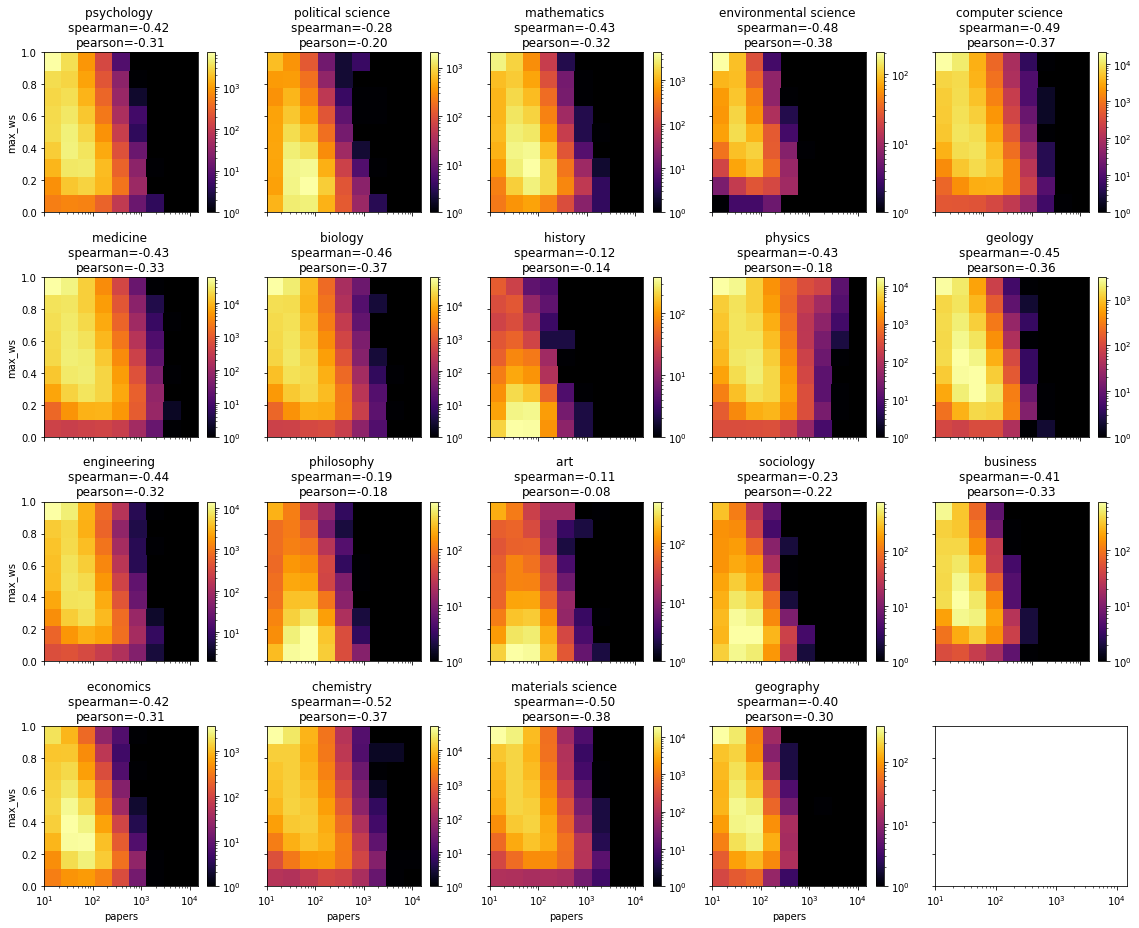

In [76]:
def _hist2d(ax, xgroup, ygroup, xspace, yspace, field_name): 
    ax.set_facecolor("black")
    im = ax.hist2d(xgroup, ygroup, bins=(xspace, yspace), cmap='inferno', norm=LogNorm()) #vmin=1,vmax=10000))
    ax.set_title("%s \nspearman=%.2f \npearson=%.2f" % (field_name, spearmanr(xgroup, ygroup)[0], pearsonr(xgroup, ygroup)[0]))
    return im
    
def hist2d(unique, fos, xdata, ydata, xkey, ykey, xbins, ybins, yscale=None, xscale=None):
    fig, axs = plt.subplots(figsize=(16, 13), nrows=4, ncols=5, sharex=True, sharey=True)
    i = 0
    for field in unique:
        xgroup = xdata[fos == field]
        ygroup = ydata[fos == field]
        if len(xgroup) < 1000:
            continue
        ax = axs[int(i/5)][i%5]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = _hist2d(ax, xgroup, ygroup, xbins, ybins, field_name=field_name)

        if yscale:
            ax.set_yscale(yscale)
        if xscale:
            ax.set_xscale(xscale)
    
        if i%5 == 0: 
            ax.set_ylabel(ykey)
        if int(i/5) == 3:    
            ax.set_xlabel(xkey)
        
        fig.colorbar(im[3], ax=ax)
        
        i += 1
        
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_%s_%s.pdf' % (xkey, ykey))
    fig.show()
    
xbins = np.logspace(np.log10(min(P)), np.log10(max(P)+1), 10)
ybins = np.linspace(min(WS), max(WS), 10)
hist2d(unique, FOS, P, WS, 'papers', 'max_ws', xbins=xbins, ybins=ybins, xscale='log', yscale=None)

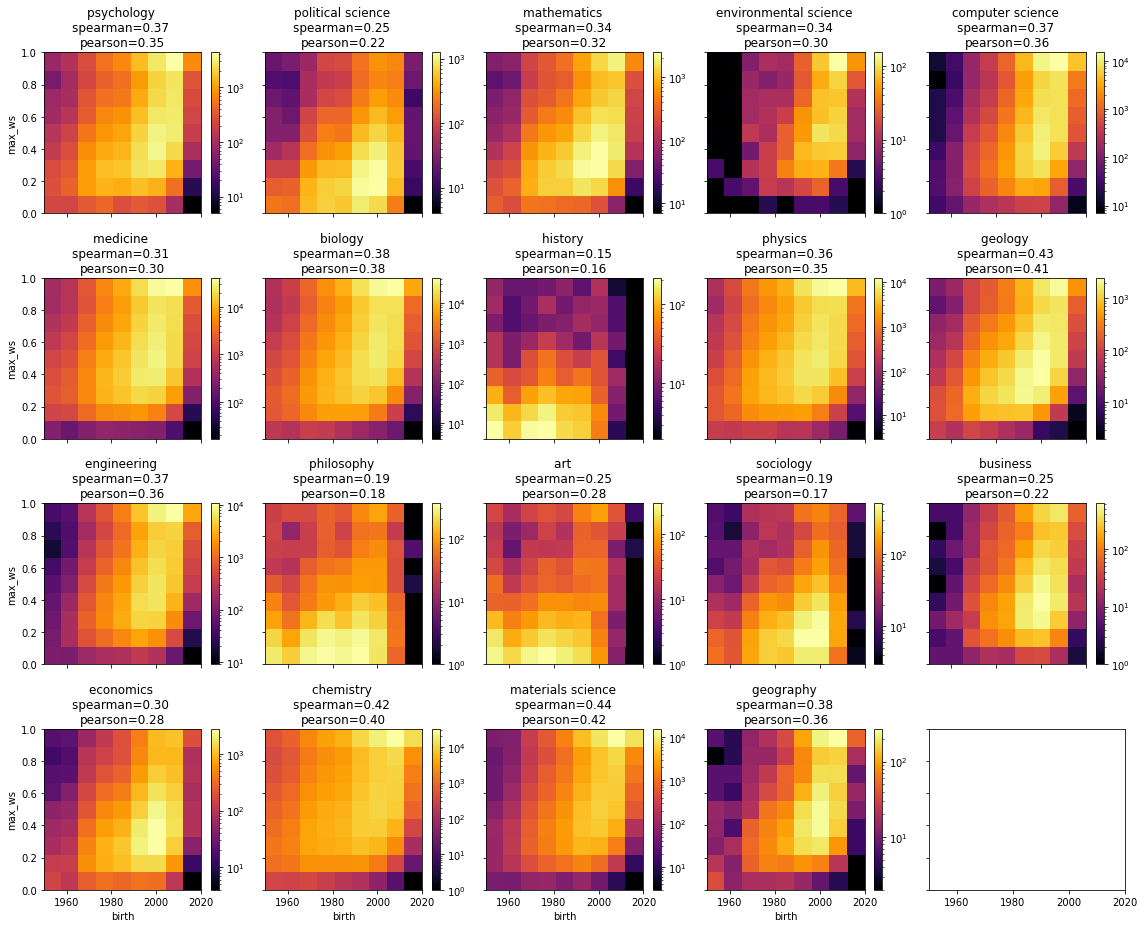

In [77]:
xbins = np.linspace(min(Y), max(Y), 10)
ybins = np.linspace(min(WS), max(WS), 10)
hist2d(unique, FOS, Y, WS, 'birth', 'max_ws', xbins=xbins, ybins=ybins, xscale=None, yscale=None)

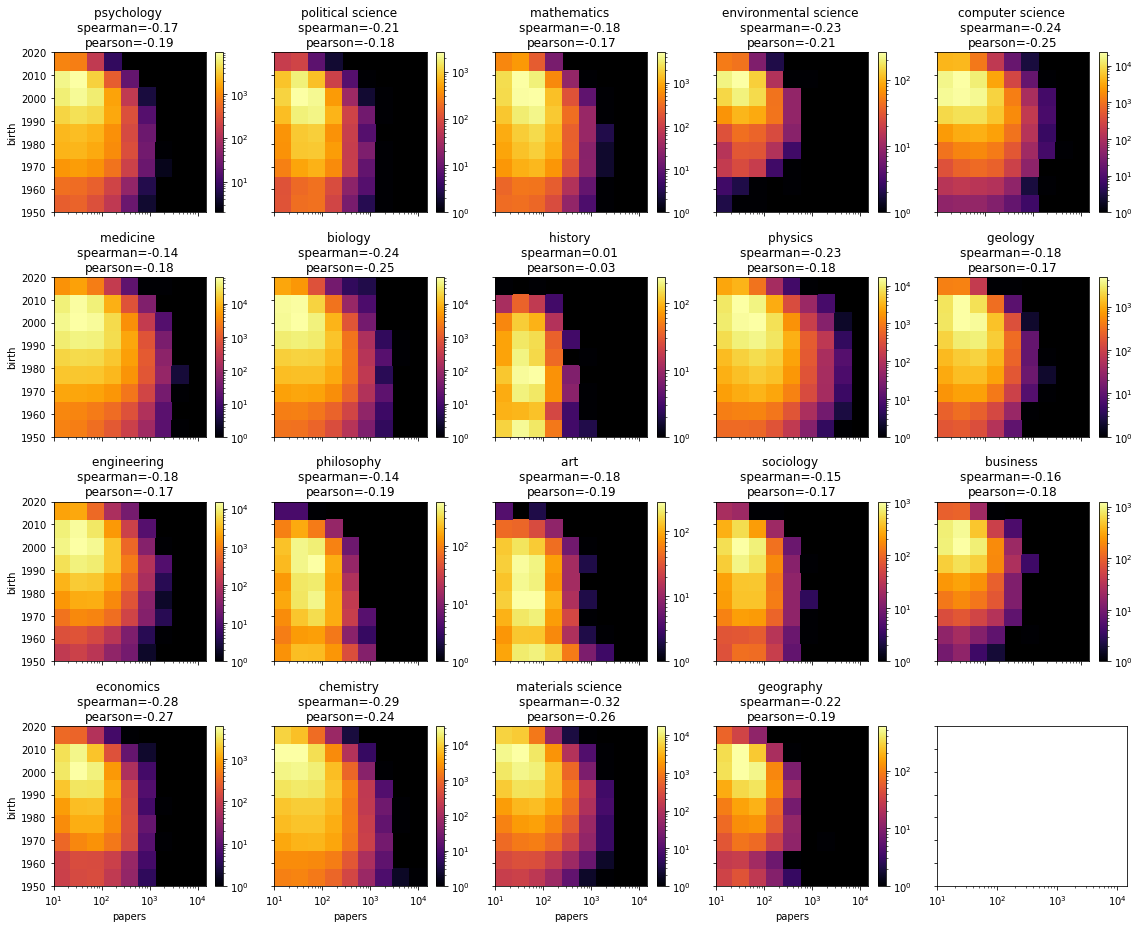

In [78]:
xbins = np.logspace(np.log10(min(P)), np.log10(max(P)+1), 10)
ybins = np.linspace(min(Y), max(Y), 10)
hist2d(unique, FOS, P, Y, 'papers', 'birth', xbins=xbins, ybins=ybins, xscale='log', yscale=None)

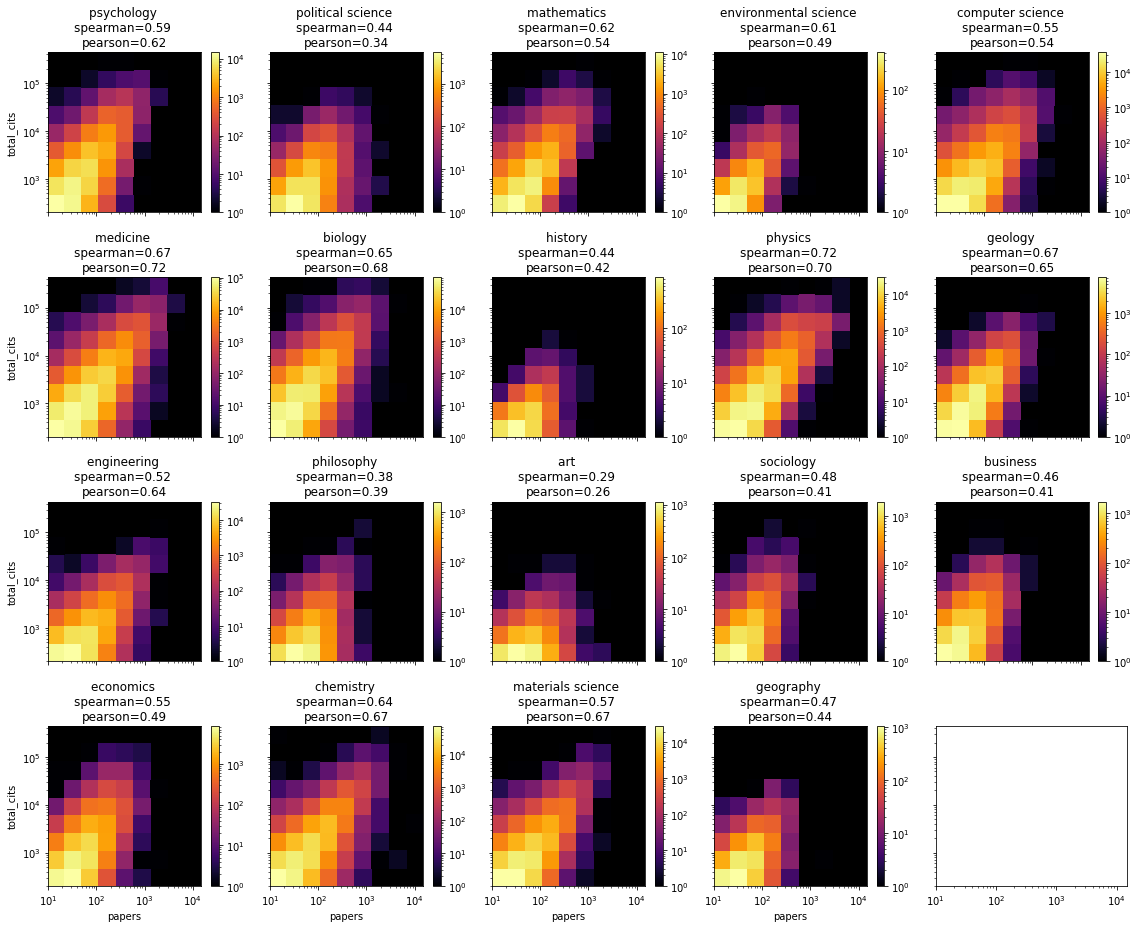

In [79]:
xbins = np.logspace(np.log10(min(P)), np.log10(max(P)+1), 10)
ybins = np.logspace(np.log10(min(C)), np.log10(max(C)+1), 10)
hist2d(unique, FOS, P, C, 'papers', 'total_cits', xbins=xbins, ybins=ybins, xscale='log', yscale='log')

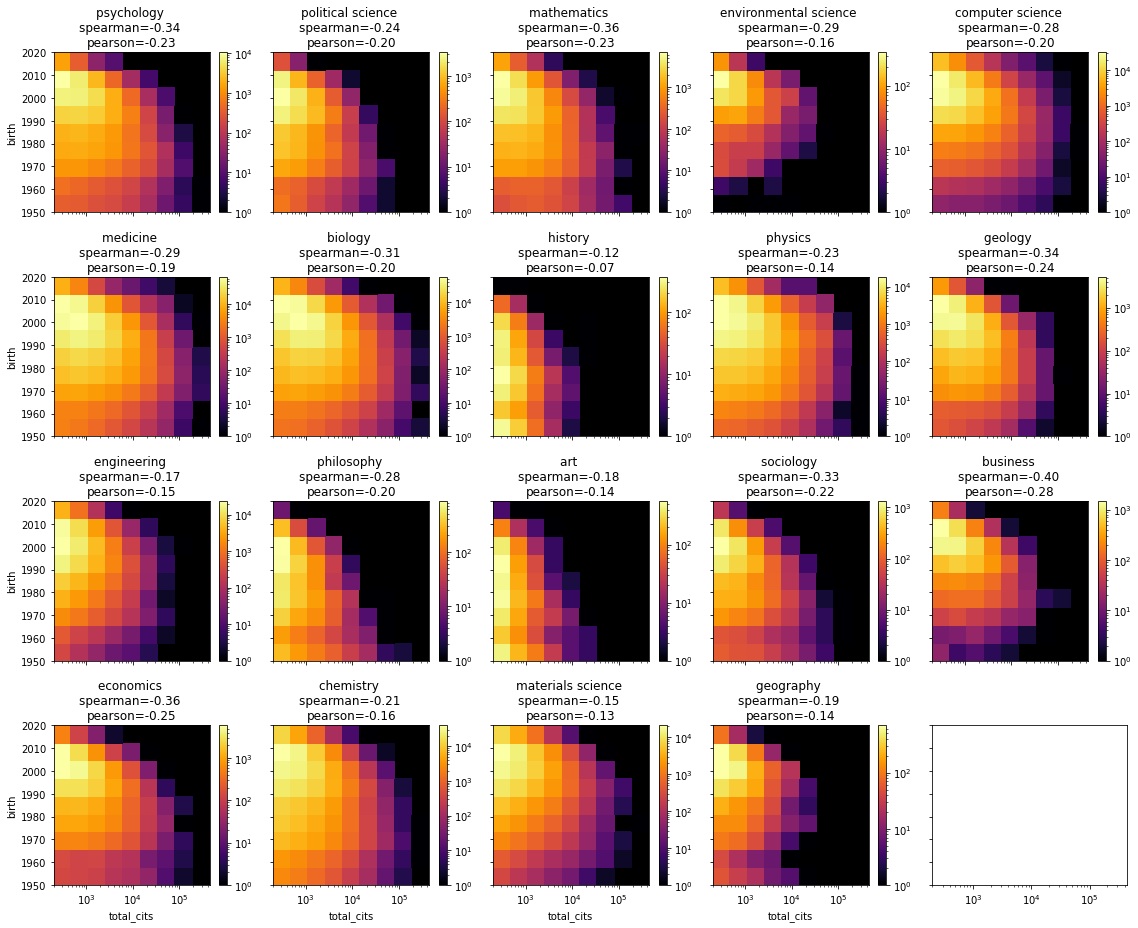

In [80]:
xbins = np.logspace(np.log10(min(C)), np.log10(max(C)+1), 10)
ybins = np.linspace(min(Y), max(Y), 10)
hist2d(unique, FOS, C, Y, 'total_cits', 'birth', xbins=xbins, ybins=ybins, xscale='log', yscale=None)

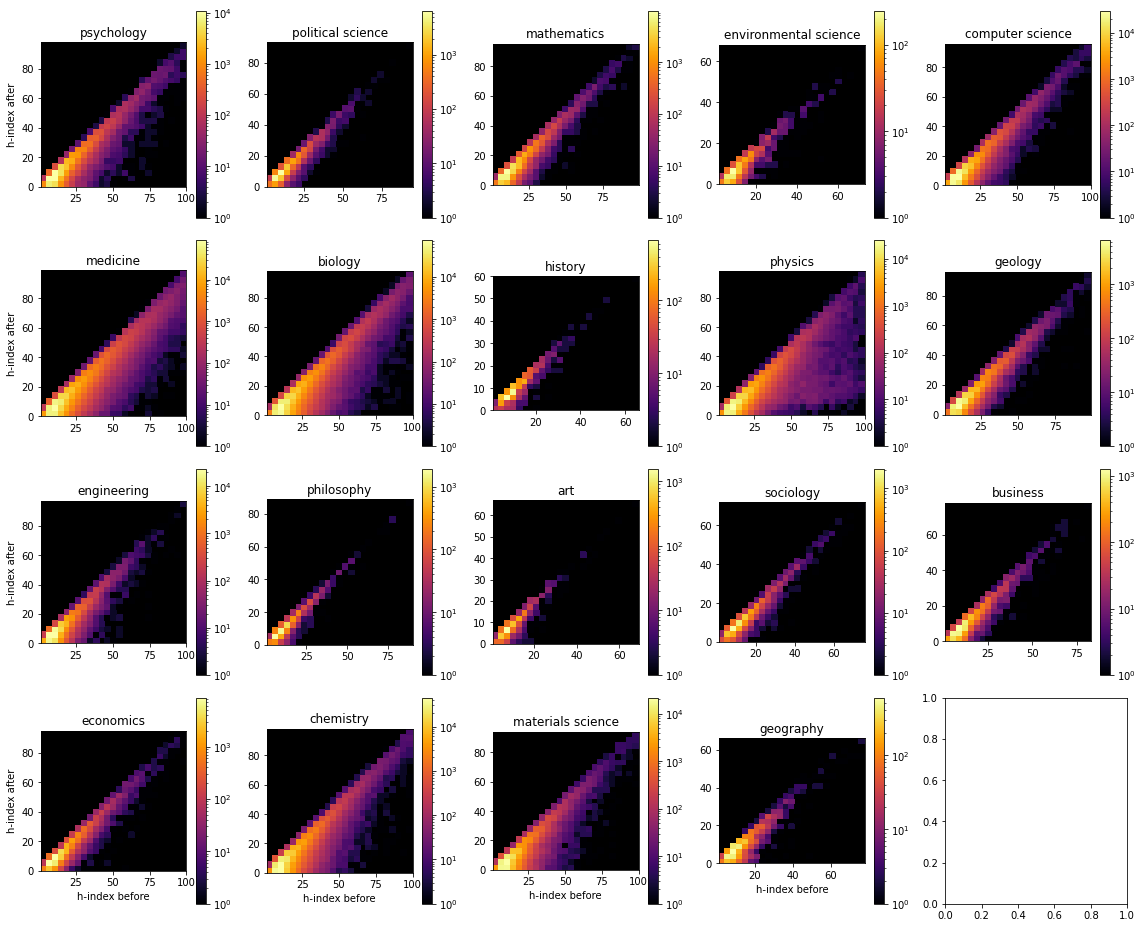

In [86]:
from s4_authors_stats import get_h_index

def _hindex_before_after(ax, idxs, field_name):
    valid_colabs_cit_list = CL[idxs]
    valid_citation_list = CH[idxs]
    valid_h_index = H[idxs]
    hindex_after = []
    
    for ccits, acits in zip(valid_colabs_cit_list, valid_citation_list):
        diff_cits = acits.copy() # json.loads(acits)
        for ctemp in ccits: # json.loads(ccits):
            diff_cits.remove(ctemp)
            
        hafter = get_h_index(diff_cits)
        hindex_after.append(hafter)
    
    hindex_before_l1 = np.asarray([row[0] for row in valid_h_index])
    hindex_after_l1 = np.asarray(hindex_after)[:,0]
    
    ax.set_facecolor("black")
    im = ax.hist2d(hindex_before_l1[hindex_before_l1 <= 100], hindex_after_l1[hindex_before_l1 <= 100], 
           norm=LogNorm(), cmap='inferno', bins=(25, 25))
    ax.set_aspect('equal')
    ax.set_title(field_name)
    
    return im, hindex_after 


def hindex_before_after():
    fig, axs = plt.subplots(figsize=(16, 13), nrows=4, ncols=5) #sharex=True, sharey=True)
    i = 0
    hafter_map = {}
    for field in unique:
        group = (FOS == field)
        if np.count_nonzero(group) < 1000:
            continue
        ax = axs[int(i/5)][i%5]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im, hafter = _hindex_before_after(ax, group, field_name=field_name)
        hafter_map[field] = hafter
    
        if i%5 == 0: 
            ax.set_ylabel('h-index after')
        if int(i/5) == 3:    
            ax.set_xlabel('h-index before')
        
        fig.colorbar(im[3], ax=ax)
        
        i += 1
        
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_before_after.pdf')
    fig.show()
    
    return hafter_map

hafter_map = hindex_before_after()

100%|██████████| 5244/5244 [00:00<00:00, 34563.39it/s]


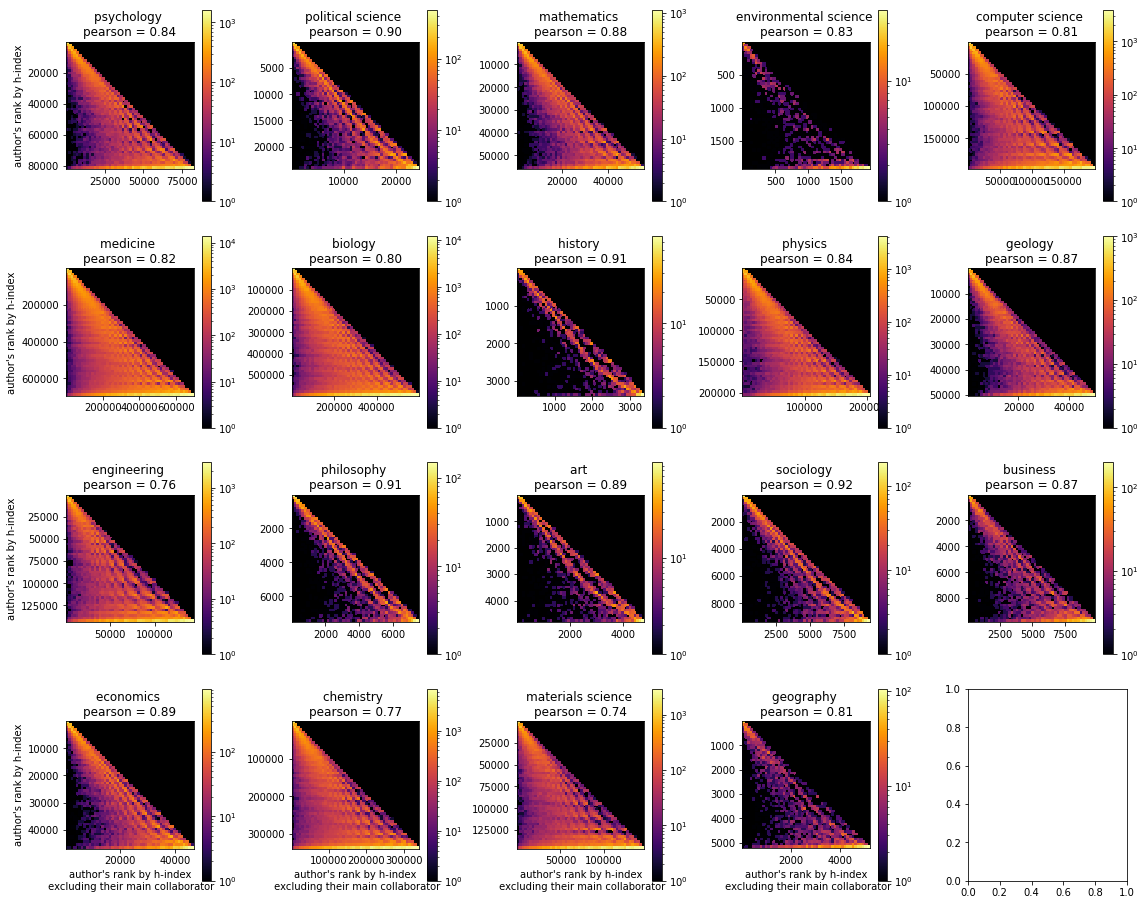

In [91]:
import tqdm
# from tqdm.auto import tqdm

def rank(values, i, new_val):
    old = values[i]
    new_pair = np.array([(new_val[0], new_val[1], new_val[2], old[3])], dtype=[('my_val1', int), ('my_val2', int), ('my_val3', int), ('my_val4', int)])
    new_rank = np.searchsorted(values, new_pair[0], side='right')
    return new_rank

def get_rank_after(hindexbefore, i, ccits, acits):
    diff_cits = acits.copy() #json.loads(acits)
    for ctemp in ccits: #json.loads(ccits):
        diff_cits.remove(ctemp)
    hafter = get_h_index(diff_cits)
    rafter = rank(hindexbefore, i, (-hafter[0], -hafter[1], -hafter[2]))
    return rafter

def _plot_rank(ax, idxs, hindex_after, field_name):
    valid_h_index = H[idxs]
    
    valid_colabs_cit_list = CL[idxs]
    valid_citation_list = CH[idxs]
    
    neg_hindex = np.array([(-row[0], -row[1], -row[2], i) for i,row in enumerate(valid_h_index)], 
                          dtype=[('my_val1', int), ('my_val2', int), ('my_val3', int), ('my_val4', int)])
    neg_hindex_sorted = np.sort(neg_hindex)
    rankbefore = rankdata(neg_hindex, method='ordinal')

    results = []
    for a,b,c in tqdm.tqdm(zip(np.arange(len(neg_hindex)), valid_colabs_cit_list, valid_citation_list), total=len(neg_hindex)):
        results.append(get_rank_after(neg_hindex_sorted, a,b,c)) 
    
    ax.set_facecolor("black")
    ax.set_aspect('equal')
    
    im = ax.hist2d(rankbefore, results, bins=50, cmap='inferno', norm=LogNorm())
    ax.set_title('%s \npearson = %.2f' % (field_name, pearsonr(rankbefore, results)[0]))
    ax.invert_yaxis()
    return im


def plot_rank(hafter_map):
    fig, axs = plt.subplots(figsize=(16, 13), nrows=4, ncols=5) # sharex=True, sharey=True)
    i = 0
    for field in unique:
        group = (FOS == field)
        if np.count_nonzero(group) < 1000:
            continue
        ax = axs[int(i/5)][i%5]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = _plot_rank(ax, group, hafter_map[field], field_name=field_name)
    
        if i%5 == 0: 
            ax.set_ylabel('author\'s rank by h-index')
        if int(i/5) == 3:    
            ax.set_xlabel('author\'s rank by h-index\n excluding their main collaborator')
    
        fig.colorbar(im[3], ax=ax)
        
        i += 1
        
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_hrank.pdf')
    fig.show()
    
plot_rank(hafter_map)


In [ ]:
def _nauthors(f):
    print(f)
    chunk = pd.read_csv(f, header=None, sep='\t',
                names=['paper_id', 'doi', 'year', 'authors', 'total_cits', 'cits',])
    nauthors = []
    for _,row in chunk.iterrows():
        year = row['year']
        if not year or type(year) != type(1.0) or year < 1950:
            continue
        n = 1 + row['authors'].count(',')
        nauthors.append(n)
    del chunk
    return nauthors

files_input = glob.glob('data/PaperCompleteInfos_split/*')

pool = Pool(16)
nauthors_temp = pool.map(_nauthors, files_input)

data/PaperCompleteInfos_split/paper_comp_info_00010data/PaperCompleteInfos_split/paper_comp_info_00002data/PaperCompleteInfos_split/paper_comp_info_00006data/PaperCompleteInfos_split/paper_comp_info_00016data/PaperCompleteInfos_split/paper_comp_info_00020data/PaperCompleteInfos_split/paper_comp_info_00028data/PaperCompleteInfos_split/paper_comp_info_00000data/PaperCompleteInfos_split/paper_comp_info_00014data/PaperCompleteInfos_split/paper_comp_info_00012data/PaperCompleteInfos_split/paper_comp_info_00026data/PaperCompleteInfos_split/paper_comp_info_00008data/PaperCompleteInfos_split/paper_comp_info_00004data/PaperCompleteInfos_split/paper_comp_info_00024data/PaperCompleteInfos_split/paper_comp_info_00030data/PaperCompleteInfos_split/paper_comp_info_00022data/PaperCompleteInfos_split/paper_comp_info_00018

